In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных
Используем данные о [The Austin Animal Center](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-outcomes-and#aac_shelter_outcomes.csv).

In [3]:
# Загрузим данные датасета
data = pd.read_csv(r'C:\Users\Masha\virtualenvs\tensorflow\data\aac_shelter_outcomes.csv', sep=",")

In [4]:
# размер набора данных
data.shape

(78256, 12)

In [5]:
# типы колонок
data.dtypes

age_upon_outcome    object
animal_id           object
animal_type         object
breed               object
color               object
date_of_birth       object
datetime            object
monthyear           object
name                object
outcome_subtype     object
outcome_type        object
sex_upon_outcome    object
dtype: object

In [6]:
# проверим есть ли пропущенные значения
data.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23886
outcome_subtype     42293
outcome_type           12
sex_upon_outcome        2
dtype: int64

In [7]:
# Первые 5 строк датасета
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [8]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 78256


# 1. Обработка пропусков в данных
## 1.1. Простые стратегии - удаление или заполнение нулями

In [9]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((78256, 12), (78256, 7))

In [10]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((78256, 12), (17699, 12))

In [11]:
data_new_1.head()

,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00
1,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00
2,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00
3,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00
4,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00


In [12]:
# Заполнение всех пропущенных значений нулями
# В данном случае это некорректно, так как нулями заполняются в том числе категориальные колонки
data_new_3 = data.fillna(0)
data_new_3.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,0,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,0,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,0,Rabies Risk,Euthanasia,Unknown


# 1.2. "Внедрение значений" - импьютация (imputation)
## 1.2.1. Обработка пропусков в категориальных данных

In [13]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка age_upon_outcome. Тип данных object. Количество пустых значений 8, 0.01%.
Колонка name. Тип данных object. Количество пустых значений 23886, 30.52%.
Колонка outcome_subtype. Тип данных object. Количество пустых значений 42293, 54.04%.
Колонка outcome_type. Тип данных object. Количество пустых значений 12, 0.02%.
Колонка sex_upon_outcome. Тип данных object. Количество пустых значений 2, 0.0%.


In [14]:
cat_temp_data = data[['name']]
cat_temp_data.head()

,name
0,NaN
1,Lucy
2,*Johnny
3,Monday
4,NaN


In [15]:
cat_temp_data['name'].unique()

array([nan, 'Lucy', '*Johnny', ..., 'Wonder Woman', 'Eisley',
       'Allee Chat'], dtype=object)

In [16]:
cat_temp_data[cat_temp_data['name'].isnull()].shape

(23886, 1)

In [17]:
from sklearn.impute import SimpleImputer

In [18]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['Bella'],
       ['Lucy'],
       ['*Johnny'],
       ...,
       ['Bella'],
       ['Bella'],
       ['Bella']], dtype=object)

In [19]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['$Kittlez', '*', '* Bo Derek', ..., 'Zydeco', 'Zyere', 'Zz'],
      dtype=object)

In [20]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='!!!')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['!!!'],
       ['Lucy'],
       ['*Johnny'],
       ...,
       ['!!!'],
       ['!!!'],
       ['!!!']], dtype=object)

In [21]:
np.unique(data_imp3)

array(['!!!', '$Kittlez', '*', ..., 'Zydeco', 'Zyere', 'Zz'], dtype=object)

In [22]:
data_imp3[data_imp3=='!!!'].size

23886

# 2. Преобразование категориальных признаков в числовые

In [23]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,Bella
1,Lucy
2,*Johnny
3,Monday
4,Bella
5,*Edgar
6,Bella
7,*Ella
8,Lucy
9,*Frida


## 2.1. Кодирование категорий целочисленными значениями

In [24]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [25]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [26]:
cat_enc['c1'].unique()

array(['Bella', 'Lucy', '*Johnny', ..., 'Wonder Woman', 'Eisley',
       'Allee Chat'], dtype=object)

In [27]:
np.unique(cat_enc_le)

array([    0,     1,     2, ..., 14571, 14572, 14573])

In [28]:
le.inverse_transform([0, 1, 2, 3])

array(['$Kittlez', '*', '* Bo Derek', '* Daphne'], dtype=object)

## 2.2. Кодирование категорий наборами бинарных значений

In [29]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [30]:
cat_enc.shape

(78256, 1)

In [31]:
cat_enc_ohe.shape

(78256, 14574)

In [32]:
cat_enc_ohe

<78256x14574 sparse matrix of type '<class 'numpy.float64'>'
	with 78256 stored elements in Compressed Sparse Row format>

In [33]:
cat_enc_ohe.todense()[0:10]

MemoryError: 

In [ ]:
cat_enc.head(10)

## 2.3. Pandas get_dummies - быстрый вариант one-hot кодирования

In [ ]:
pd.get_dummies(cat_enc).head()

In [34]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

,name_$Kittlez,name_*,name_* Bo Derek,name_* Daphne,name_* Henry,name_* Joanie,name_* Mario,name_*'Stache,name_**Jamie,name_*3Ds,...,name_Zumi,name_Zumia,name_Zuri,name_Zury,name_Zuzu,name_Zuzy,name_Zydeco,name_Zyere,name_Zz,name_nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# 3. Масштабирование данных
Термины "масштабирование" и "нормализация" часто используются как синонимы. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины.

In [42]:
# Будем анализировать данные на выборке по обнаружению болезни болезни сердца у пациентов
data_heart = pd.read_csv(r'C:\Users\Masha\virtualenvs\tensorflow\data\heart.csv', sep=",")

In [43]:
data_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [44]:
# типы колонок
data_heart.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

## 3.1. MinMax масштабирование

In [45]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data_heart[['chol']])

c:\users\masha\virtualenvs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


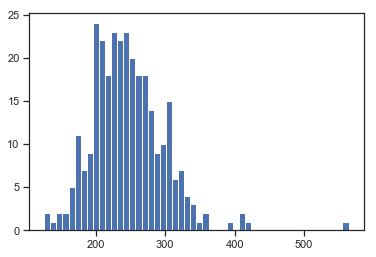

In [46]:
plt.hist(data_heart['chol'], 50)
plt.show()

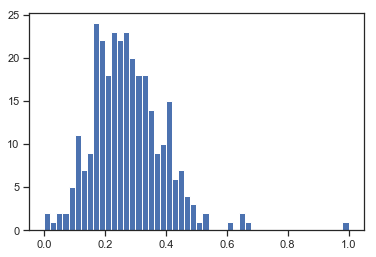

In [47]:
plt.hist(sc1_data, 50)
plt.show()

## 3.2. Масштабирование данных на основе Z-оценки - StandardScaler

In [48]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['chol']])

c:\users\masha\virtualenvs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\masha\virtualenvs\tensorflow\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


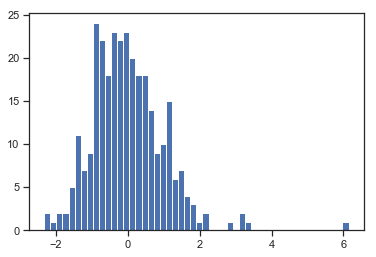

In [49]:
plt.hist(sc2_data, 50)
plt.show()

## 3.3. Нормализация данных

In [50]:
sc3 = Normalizer()
sc3_data = sc3.fit_transform(data[['chol']])

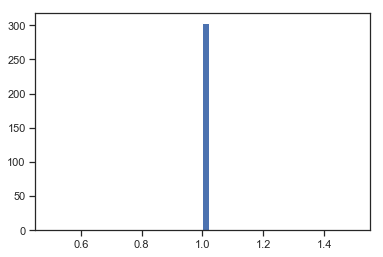

In [51]:
plt.hist(sc3_data, 50)
plt.show()